In [17]:
# Load the usual culprits
import os, sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Load some imports from dipy
from dipy.data import fetch_cenir_multib, read_cenir_multib, gradient_table
from dipy.segment.mask import median_otsu

# Modify the module path (if required) so that we can import
# modules from this repository
module_path = os.path.join(os.path.abspath(os.path.join('..')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices
from freewater_runner import FreewaterRunner

### Loading Example data from dipy

Since we cannot find publicly available single shell data, we use multishell data from data and transform it to look like single shell data

In [2]:
# # This downloads only eddy-current/motion corrected data (a couple of GB will be downloaded)
# fetch_cenir_multib(with_raw=False)

In [3]:
# Read just one shell of data for b-value = 1000
img, gtab = read_cenir_multib([1000])
data = img.get_data()

Dataset is already in place. If you want to fetch it again please first remove the folder /home/sld0465/.dipy/cenir_multib 


In [4]:
# Convert multishell data to look like single shell data

# Take an average of all the b0 values
avg_b0_data = data[:,:,:,gtab.b0s_mask].mean(axis=-1)[:,:,:, np.newaxis]
# Concatenate the b0 average with the non-b0 data
ss_data = np.concatenate((avg_b0_data, data[:,:,:, ~gtab.b0s_mask]), axis=-1)

# extract the relevant parts of the bvals and the bvecs
ss_bval = np.concatenate((np.array([0.]), gtab.bvals[~gtab.b0s_mask]))
ss_bvecs = np.concatenate( (np.array([0., 0., 0.])[np.newaxis, :], gtab.bvecs[~gtab.b0s_mask, :]))

# Now we have a single shell gradient table
ss_gtab = gradient_table(ss_bval, ss_bvecs, big_delta=gtab.big_delta, 
                         small_delta=gtab.small_delta, b0_threshold=gtab.b0_threshold)

### (Alternative) Loading single shell data from separate files 

This is the more common usecase

In [5]:
# # If the data is already single shell data in separate files
# # fdwi (filename of dwi file)
# # fbval (filename of bval file)
# # fbvec (filename of vec file)

# import nibabel as nib
# from dipy.io import read_bvals_bvecs
# from dipy.core.gradients import gradient_table

# img = nib.load(fdwi)
# data = img.get_data()
# bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
# gtab = gradient_table(bvals, bvecs)

### Process Single shell data

In [6]:
# we remove the background of the image to avoid unnecessary calculations.
maskdata, mask = median_otsu(ss_data, 4, 2, False, vol_idx=[0], dilate=1)

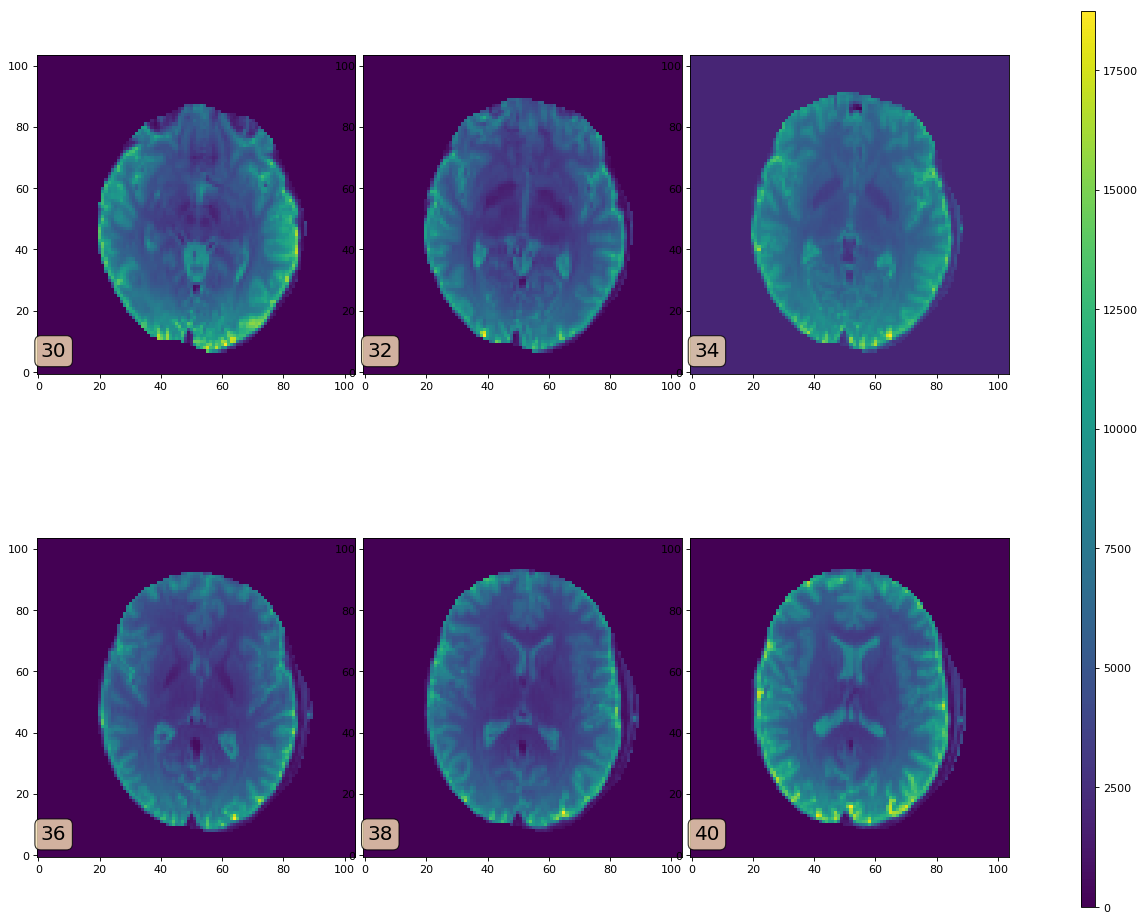

In [7]:
# plot the b0 image for a few z-axis slices
plot_3d_z_indices(maskdata[:,:,:,0], idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)

In [8]:
# take a small region of the original data and make a copy because we are going to modify it
smalldata = maskdata[30:70,30:70,30:41, :].astype(np.float_, copy=True)
smalldata.shape

(40, 40, 11, 183)

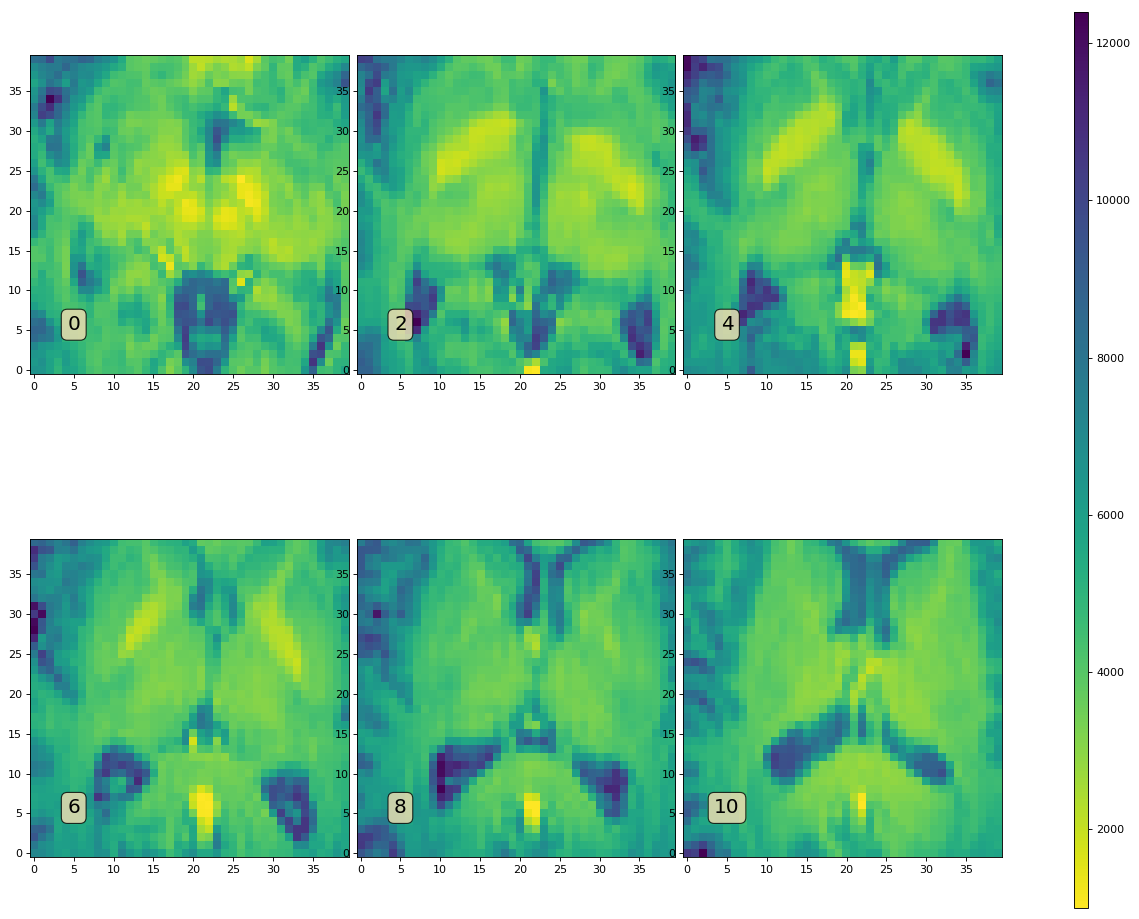

In [9]:
# Plot a few slices of the smaller dataset
plt.set_cmap("viridis_r")
plot_3d_z_indices(smalldata[:,:,:,0], idx_list=range(0, 11, 2) , num_rows=2, num_cols=3)

# Now let us work with smalldata and get the freewater maps, FA, corrected-FA etc

In [10]:
smalldata.nbytes / 1e6

25.7664

In [11]:
freewater_runner = FreewaterRunner(smalldata, ss_gtab)
freewater_runner.LOG = False # turn off logging for this example
freewater_runner.run_model(num_iter=100, dt=0.001)

Stissue = 719.733457397 : Swater = 10573.4928242
Single shell bvalue = 1000.0
Attenuation_min = 0.007, Attenuation_max = 0.990
Ahat.shape = (40, 40, 11, 183)
Awater_k = 0.05
f_init.shape = (40, 40, 11, 1)


#### Check for model convergence

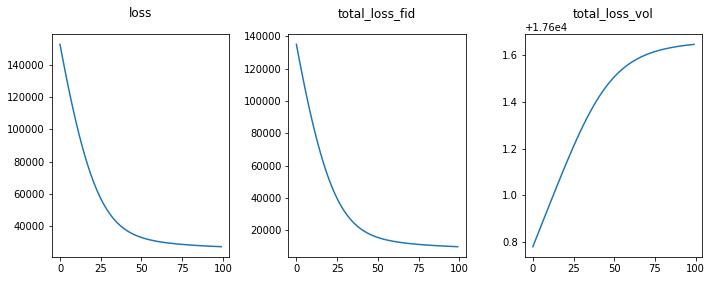

In [12]:
freewater_runner.plot_loss()

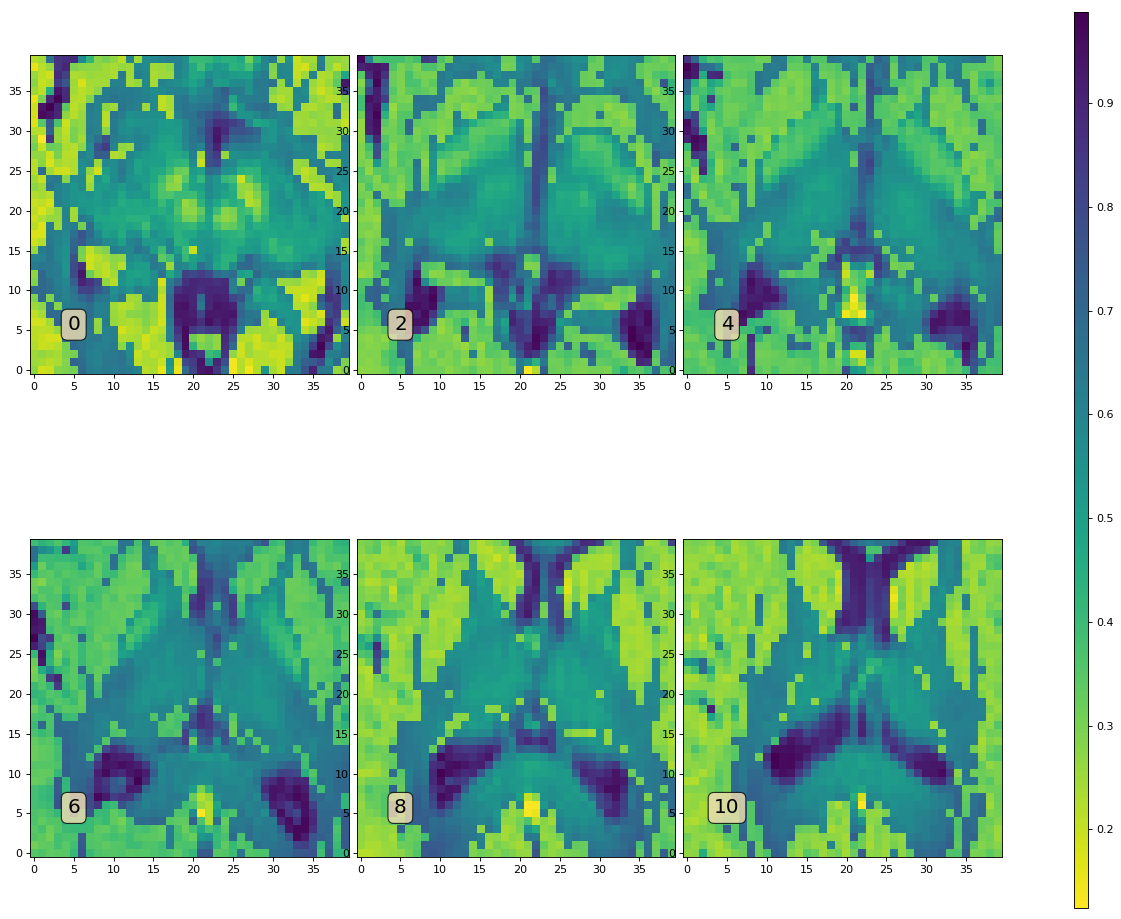

In [13]:
# Free water map after iterations
plt.set_cmap("viridis_r")
plot_3d_z_indices(freewater_runner.get_fw_map(), idx_list=range(0, 11, 2) , num_rows=2, num_cols=3)

### Mean Diffusivity (free water corrected)

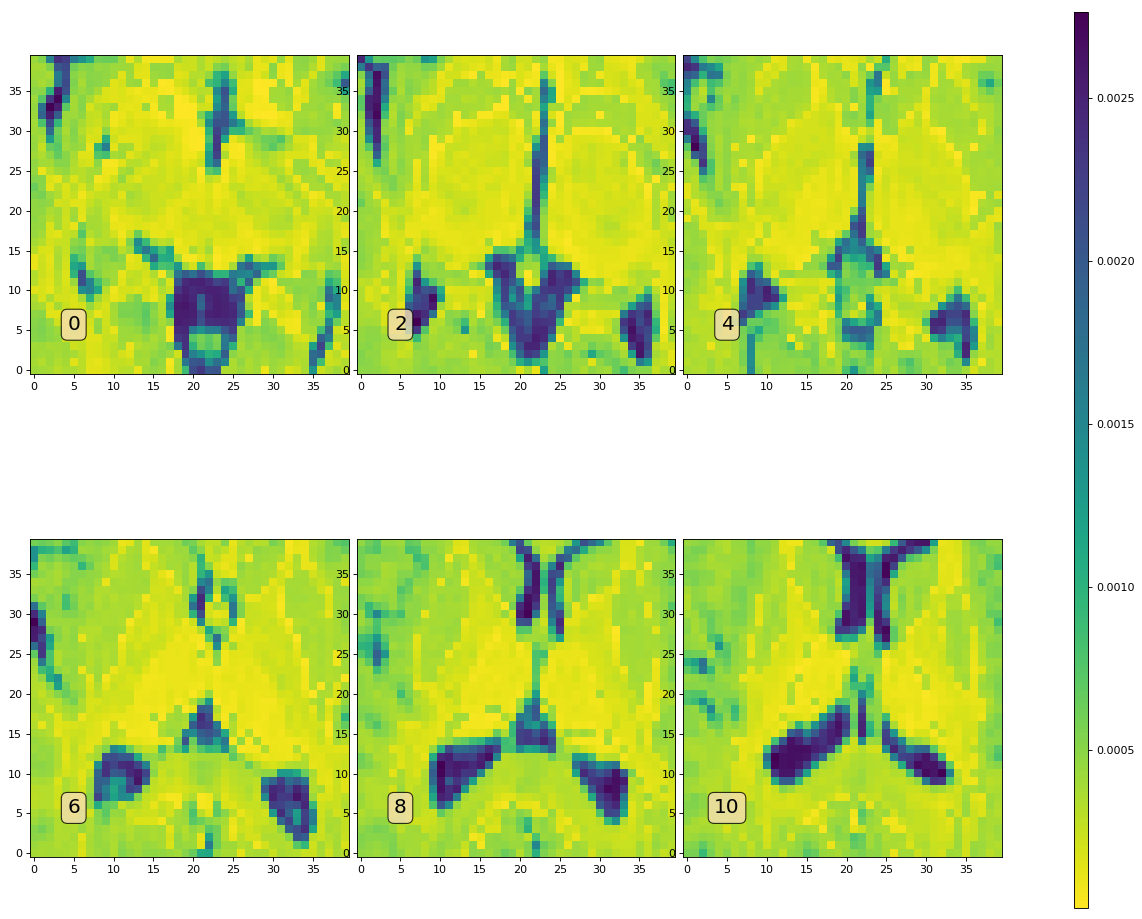

In [14]:
plt.set_cmap("viridis_r")
plot_3d_z_indices(freewater_runner.get_fw_md(), idx_list=range(0, 11, 2) , num_rows=2, num_cols=3)

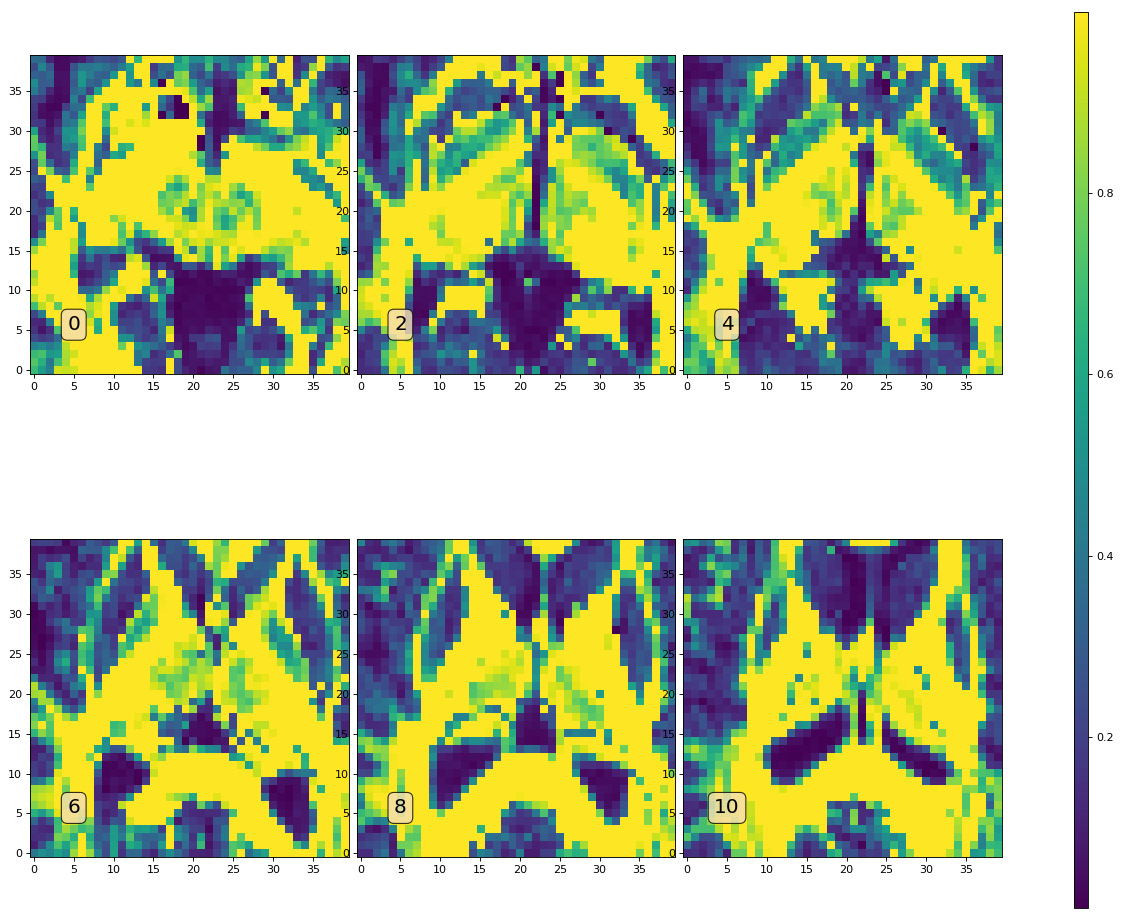

In [15]:
### Freewater corrected Fractional Anisotropy
plt.set_cmap("viridis")
plot_3d_z_indices(freewater_runner.get_fw_fa(), idx_list=range(0, 11, 2) , num_rows=2, num_cols=3)

In [16]:
# Save the free water map somewhere
#import nibabel as nib
#fw_file = "freewater.nii.gz"
#nib.save(nib.Nifti1Image((1 - fw_gd.f).squeeze(), img.affine), fw_file)